<a href="https://colab.research.google.com/github/danielsaggau/LDSI_Project/blob/master/Generating_Legal_Text_with_Distil_GPT2_based_on_raw_Courtlistener_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
if os.environ.get("COLAB_GPU", False):
    !pip install -U datasets transformers
import warnings
import re
import random
import datasets
import transformers
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from transformers import AutoTokenizer, TFGPT2LMHeadModel
from datasets import Dataset, load_dataset
import re
import json
import io
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from tensorflow.keras import activations, optimizers, losses
from spacy.lang.en import English
from spacy.attrs import ORTH
from tensorflow import keras

2.6.0
4.9.2


In [ ]:
pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
# Log Level and suppress extensive tf warnings
os.environ["TRANSFORMERS_VERBOSITY"] = "info"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
print(transformers.__version__)
PATH_BASE ="/content"

In [ ]:
data = pd.read_pickle("/Users/danielsaggau/PycharmProjects/pythonProject/data/opinions_data.pkl")

#subset to data that also entails actual opinions; remove page count = 0 / NaN
data = data[~data['page_count'].isnull()] # remove empty pages

text = data['plain_text']
author = data['author']
url = data['download_url']
html = data['html']
id = data['id']

text = data['plain_text'] # subset
# cleaning text file
text = text.replace("plain_text", " ")
text = text.replace("  ", " ")

text = text.str.replace("\n"," ")
text = text.str.replace("FILED", "")
text = text.str.replace("NOT FOR PUBLICATION", "")
text = text.str.replace("FOR PUBLICATION", "")
text = text.str.replace("UNITED STATES COURT OF APPEALS", "")
text = text.str.replace("U.S. COURT OF APPEALS", "")
text = text.str.replace("U .S. COURT OF APPEALS", "")
text = text.str.replace("U .S. COURT OF APPEALS", "")
text = text.str.replace("UNITED STATES OF AMERICA", "")
text = text.str.replace("\x0c","")
text = text.str.replace("\uf8fc","")
text = text.str.replace("\uf8fd","")
text = text.str.replace("\uf8fe", " ")
text = text.str.replace("FOR THE NINTH CIRCUIT", "")
text = text.str.replace("Appeal from the United States District Court", "")
text = text.str.replace("[*]","")
text = text.str.replace("\*\*","")
text = text.str.replace("\n\n","")
text = text.str.replace("MOLLY C. DWYER, CLERK", " ")
text = text.str.replace("U .S. C O U R T OF APPE ALS", " ")
text = text.str.replace("  ", " ")
data['length'] = text.str.len()


text.to_csv('/Users/danielsaggau/PycharmProjects/pythonProject/data/output.txt', sep='\n', index=False)

In [ ]:
# removing xml markup, symbols and starting text
text = open("/Users/danielsaggau/PycharmProjects/pythonProject/data/output.txt", "r").read()

nlp = English()
nlp.add_pipe("sentencizer")

# adding special tokens
nlp.tokenizer.add_special_case('§.', [{ORTH: '§.'}])
nlp.tokenizer.add_special_case('Cir.', [{ORTH: 'Cir.'}])
nlp.tokenizer.add_special_case('Fed.', [{ORTH: 'Fed.'}])
nlp.tokenizer.add_special_case('NO.', [{ORTH: 'NO.'}])
nlp.tokenizer.add_special_case('App.', [{ORTH: 'App.'}])
nlp.tokenizer.add_special_case('Civ.', [{ORTH: 'Civ.'}])
nlp.tokenizer.add_special_case('No.', [{ORTH: 'No.'}])
nlp.tokenizer.add_special_case('Dkt.', [{ORTH: 'Dkt.'}])
nlp.tokenizer.add_special_case('et al.', [{ORTH: 'et al.'}])
nlp.tokenizer.add_special_case('D.C.', [{ORTH: 'D.C.'}])
nlp.tokenizer.add_special_case('No.', [{ORTH: 'No.'}])
nlp.tokenizer.add_special_case('Nos.', [{ORTH: 'Nos.'}])
nlp.tokenizer.add_special_case('Fed.', [{ORTH: 'Fed.'}])
nlp.tokenizer.add_special_case('U.S.C.', [{ORTH: 'U.S.C.'}])
nlp.tokenizer.add_special_case(' F.', [{ORTH: 'F.'}])
nlp.tokenizer.add_special_case(' R.', [{ORTH: 'R.'}])
nlp.tokenizer.add_special_case(' P.', [{ORTH: 'P.'}])
nlp.tokenizer.add_special_case(' n.', [{ORTH: ' n.'}])
nlp.tokenizer.add_special_case(' v.', [{ORTH: ' v.'}]) # versus
nlp.tokenizer.add_special_case('Univ.', [{ORTH: 'Univ.'}])
nlp.tokenizer.add_special_case('Jr.', [{ORTH: 'Jr.'}])
nlp.tokenizer.add_special_case('I.N.S.', [{ORTH: 'I.N.S.'}])
nlp.tokenizer.add_special_case('OR.', [{ORTH: 'OR.'}])
nlp.tokenizer.add_special_case('REV.', [{ORTH: 'REV.'}])
nlp.tokenizer.add_special_case('STAT.', [{ORTH: 'STAT.'}])
doc = nlp(text[:1000000])
sentences = list(sents.text for sents in doc.sents) # ensure that we get strings and not spans

In [ ]:
batch = []
for sent in sentences:
    sent_new = " ".join([sent, '<eos>'])
    batch.append(sent_new)
    print("After adding tokens: ", sent_new, '\n')

with open("data/training.txt", "w") as fp:
     json.dump(batch, fp)

In [ ]:
with open("data/training.txt", "r") as fp:
     b = json.load(fp)

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
RE_SPLITTER = '<eos>'

MODEL_MAX_LEN = 256 

sent= []

def chunk_text(text, num_tok):
    text_sent = \
        [sent.strip() + '.' for sent in re.split(RE_SPLITTER, text) if len(sent) > 1]

    # calculate number of tokens per sentence
    num_tok_sent = [len(tokenizer.tokenize(sent)) for sent in text_sent]

    # calculate chunk dimension to fit into model
    n = int(np.ceil(num_tok / MODEL_MAX_LEN))
    len_chunk = int(num_tok / n)

    # get a more uniform splitting to avoid splits
    # which are too short at the end
    if len_chunk + 50 > MODEL_MAX_LEN:
        len_chunk = int(num_tok / (n + 1))

    len_curr = 0
    text_curr = []
    text_chunk = []
    for te, len_sent in zip(text_sent, num_tok_sent):

        if len_curr + len_sent < len_chunk:
            text_curr.append(te)
            len_curr += len_sent

        elif len_curr + len_sent >= MODEL_MAX_LEN:
            text_chunk.append(text_curr)

            text_curr = [te]
            len_curr = len_sent

        else:  # >= len_chunk && < MODEL_MAX_LEN
            text_curr.append(te)
            text_chunk.append(text_curr)

            text_curr = []
            len_curr = 0

    if len_curr > 0:
        text_chunk.append(text_curr)

    return text_chunk


b = ''.join(b)
chunky = chunk_text(b, 256)

#optional 

with open("data/chunks.txt", "r") as fp:
    b = json.load(fp)
with open("data/sentence_chunks.json", "w") as fp:
    json.dump(chunky, fp)

In [ ]:
flat_list = [item for sublist in chunky for item in sublist]
with open("data/flat_list.json", "w") as fp:
    json.dump(flat_list, fp)

In [4]:
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  ['10.24.60.50:8470']
REPLICAS:  8


In [5]:
data = pd.read_json("/content/flat_list.json")
data.to_csv("/content/data.csv", index=False)

In [6]:
data[:100]

,0
0,""" APR 03 2018 UNITED STATES COURT OF APPEALS MOLLY C. DWYER, CLERK U.S. COURT OF APPEALS FOR THE NINTH CIRCUIT AL SAVIN, an Individual and PartialNo.."
1,15-55993 Beneficiary of The Flora Peralta Irrevocable Family Trust; et al..
2,",D.C. No.."
3,"5:14-cv-01180-SJO-E Plaintiffs-Appellants, v.MEMORANDUM GLORIA SAVIN, AKA Gloria De La Cruz, an individual; et al.,."
4,Defendants-Appellees..
5,"Appeal from the United States District Court for the Central District of California S. James Otero, District Judge, Presiding Submitted March 30, 2018 Before: GOODWIN, LEAVY, and SILVERMAN, Circuit Judges.."
6,"Al Savin, Lucia Savin, and William Peralta appeal pro se from the district court’s judgment on the pleadings and summary judgment in their 42 U.S.C. This disposition is not appropriate for publication and is not precedent except as provided by Ninth Circuit Rule 36-3.."
7,The panel unanimously concludes this case is suitable for decision without oral argument..
8,See Fed. R. App..
9,P. 34(a)(2). §.


In [7]:
data = pd.read_csv("/content/data.csv")
data = Dataset.from_pandas(data)
data.rename_column("0", "text")

Dataset({
    features: ['text'],
    num_rows: 7651
})

In [8]:
EOS_TOKEN = "<|endoftext|>"
PAD_TOKEN = "<|pad|>"
MAX_TOKENS = 256 # was 128

tokenizer = AutoTokenizer.from_pretrained(
    "gpt2",
    eos_token=EOS_TOKEN,
    pad_token=PAD_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)

# adding further special cases
special_cases = ['Cir.','Fed.','No.','NO','App.','Civ.', 'Dkt.', 'et al.','Nos.','U.S.C.','F.',
                 'R.', 'n.', 'v.', 'Univ.', 'Jr.','I.N.S.', 'OR.', 'REV.', 'STAT.','D.C.']

tokenizer.add_tokens(special_cases, special_tokens = False)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


20

In [9]:
output = {}

# defining tokenizer function
def tokenize_function(examples, tokenizer=tokenizer):
    # Add start and end token to each comment
    examples = [ex + EOS_TOKEN for ex in examples["0"]]
    # tokenizer created input_ids and attention_mask as output
    output = tokenizer(
        examples,
        add_special_tokens=True,  # Only adds pad not eos and bos
        max_length=MAX_TOKENS,
        truncation=True,
        pad_to_max_length=True,
    )
    # shift labels for next token prediction
    # set padding token labels to -100 which is ignored in loss computation
    output["labels"] = [x[1:] for x in output["input_ids"]]
    output["labels"] = [
        [-100 if x == tokenizer.pad_token_id else x for x in y]
        for y in output["labels"]
    ]
    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output

data = data.map(
    tokenize_function,
    batched=True,
    num_proc=strategy.num_replicas_in_sync,
    remove_columns=["0"],
    load_from_cache_file=True,
)
data.save_to_disk("/content/dataset_format")
data = datasets.load_from_disk("/content/dataset_format")
data.set_format(type="python", columns=["input_ids", "attention_mask", "labels"])
data = data.train_test_split(
    test_size=0.20, shuffle=True, seed=1, load_from_cache_file=True
)

In [10]:
# convert to tensors and split data
train_tensor_inputs = tf.convert_to_tensor(data["train"]["input_ids"])
train_tensor_labels = tf.convert_to_tensor(data["train"]["labels"])
train_tensor_mask = tf.convert_to_tensor(data["train"]["attention_mask"])
train = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": train_tensor_inputs, "attention_mask": train_tensor_mask},
        train_tensor_labels,
    )
)

test_tensor_inputs = tf.convert_to_tensor(data["test"]["input_ids"])
test_tensor_labels = tf.convert_to_tensor(data["test"]["labels"])
test_tensor_mask = tf.convert_to_tensor(data["test"]["attention_mask"])
test = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": test_tensor_inputs, "attention_mask": test_tensor_mask},
        test_tensor_labels,
    )
)

In [ ]:
BATCH_SIZE_PER_REPLICA = 28
EPOCHS = 6
INITAL_LEARNING_RATE = 0.001
try:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
except NameError as e:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA
BUFFER_SIZE = len(train)

In [ ]:
# prepare data for consumption
train_ds = (train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True))
test_ds = test.batch(BATCH_SIZE, drop_remainder=True)

# Drecreasing learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    INITAL_LEARNING_RATE,
    decay_steps=500,
    decay_rate=0.7,
    staircase=True)
# reference note: initialize model, use_cache=False important! else wrong shape at loss calc
with strategy.scope():
    model = TFGPT2LMHeadModel.from_pretrained(
        "distilgpt2",
        use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    model.resize_token_embeddings(len(tokenizer))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss=model.compute_loss)
    model.summary()

In [12]:
steps_per_epoch = int(BUFFER_SIZE // BATCH_SIZE)
print(
    f"Model Params:\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
    f"Initial Learning rate: {INITAL_LEARNING_RATE}"
)

Model Params:
batch_size: 224
Epochs: 6
Step p. Epoch: 27
Initial Learning rate: 0.001


In [13]:
hist = model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=BATCH_SIZE,
    epochs=6,
    verbose=1,
)

Epoch 1/6
27/27 [==============================] - 74s 952ms/step - loss: 10.2704 - val_loss: 4.5227
Epoch 2/6
27/27 [==============================] - 18s 686ms/step - loss: 4.1525 - val_loss: 3.7248
Epoch 3/6
27/27 [==============================] - 18s 686ms/step - loss: 3.4690 - val_loss: 3.3715
Epoch 4/6
27/27 [==============================] - 19s 693ms/step - loss: 3.0537 - val_loss: 3.1862
Epoch 5/6
27/27 [==============================] - 19s 688ms/step - loss: 2.7439 - val_loss: 3.0768
Epoch 6/6
27/27 [==============================] - 18s 686ms/step - loss: 2.4911 - val_loss: 3.0172


In [ ]:
# save model
hist.save("model")

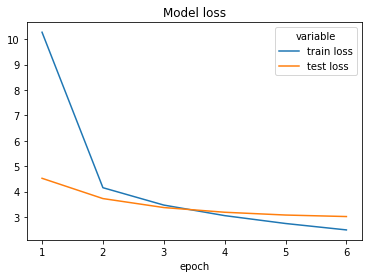

In [50]:
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss",
    ylabel="",
    xticks=range(1, loss["epoch"].max() + 1),
    xticklabels=loss["epoch"].unique(),
);

# load model

In [24]:
from transformers import pipeline

gen = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

In [51]:
text = "Fourth Amendment guarantees"

In [53]:
gen(text,max_length=180, num_return_sequences=10, return_full_text=None)

[{'generated_text': 'Fourth Amendment guarantees the right to petition for review of a decision taken in the U.S. Court of Appeals’s decision in Concepcion, 983 F.2d 1120 (9th Cir..'},
 {'generated_text': 'Fourth Amendment guarantees that a state may “entire[d] the rule that a state may perform” and that the plaintiff “s right” is inapplicable only under the laws and with that a state law has “a due process claim[] justifying a state-law action.”.'},
 {'generated_text': 'Fourth Amendment guarantees speedy trial rights by a juror, and the Supreme Court has established that it should be able to make its determination..'},
 {'generated_text': 'Fourth Amendment guarantees individual rights of aggrieved employees to recover costs of attorneys’ fees, fees, or costs directly from the prevailing arbitrator..'},
 {'generated_text': 'Fourth Amendment guarantees that the right to be free from undue means is clearly established and clearly established..'},
 {'generated_text': 'Fourth Amendment gua